We start our program with these initial commands and imports and we read the data. We will need them to respond the questions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
import csv
import re

%matplotlib inline

data_filename = 'retweets.csv'
data = pd.read_csv(data_filename)

We run these commands in order to have access to our Twitter API application.

In [ ]:
from twitter_config import config
import tweepy

auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth)

# Data Preparation

We keep only the records for which the language of the original tweet is in English.

In [931]:
q1 = pd.DataFrame()
q1 = data.loc[data.lang == 'en']
len(data.origMepGroupId.value_counts())

9

We keep only the tweets with an id and we download them.

In [932]:
list_id = q1.origTweetId.loc[~q1.origTweetId.isnull()].tolist() #convert ids column to list
tweets_list = []
tweets_new = []
#This loop helps for quicker tweet downloading
#We will download 13796 tweet texts. So, we set 138 repetitions and we download 100
#teet texts in each one.
for i in range(1,138):
    up = 101*i #set upper bound
    low = (up - 101) #set lower bound
    tweets_list.append(api.statuses_lookup(list_id[low:up])) #download the tweets
#this loop helps to convert the list composed by 100 rows list length lists to a list
for tweets in tweets_list:
    for tweet in tweets:
        tweets_new.append(tweet)

We create a dataframe friendly to user with the information we need, id numbers and text.

In [933]:
tweets_df=pd.DataFrame(columns=['id', 'text'])
count = 0
for tweet in tweets_new:
    tweets_df.loc[count] = [tweet.id] + [tweet.text]
    count+=1
tweets_df.head(3)

,id,text
0,519050739642286080,Lord Hill's written answers to EP are now on m...
1,519139901359783936,Our @SebDance asks @ABratusek about global cli...
2,519172557900365824,New:Child abuse scandal Manchester area - wors...


Join the dataframes based on the filtered ids from the dataset given.

In [934]:
q1 = q1.merge(tweets_df, left_on='origTweetId', right_on='id', how = 'outer')
del q1['id']

Create a new csv file from the previous dataframe. We will use it as our new complete dataset.

In [953]:
q1.to_csv('complete_dataset.csv')

Read the new file.

In [954]:
data_filename = 'complete_dataset.csv'
data = pd.read_csv(data_filename)

We group the tweet ids by the original MEP group id.

In [955]:
groupby = data.groupby(['origMepGroupId'])['origTweetId'].count()
groupby

origMepGroupId
0     358
1    3270
2    1255
3    1872
4    2139
5    1150
6    3827
7      23
8       1
Name: origTweetId, dtype: int64

We delete the rows where there are MEP groups with very few tweets.

In [956]:
groupby = groupby.loc[groupby.values >= 50]
data=data.loc[(data.origMepGroupId.isin(groupby.index)) & (data.text.isnull()!= True)]
len(data.origMepGroupId.value_counts())

7

# Clustering

We tokenize the text.

In [1006]:
vect = CountVectorizer(min_df=10, max_df=0.50, strip_accents = 'unicode', 
                       lowercase = True, stop_words = 'english',
                      token_pattern=r"(?u)(\b\w\w+\b)(?<!https)(?<!http)(?<!\d)")
corpus = data.text
X = vect.fit_transform(corpus)
len(vect.vocabulary_)

2393

We perform clustering with K-Means. We use elbow method to find the best number of clusters.

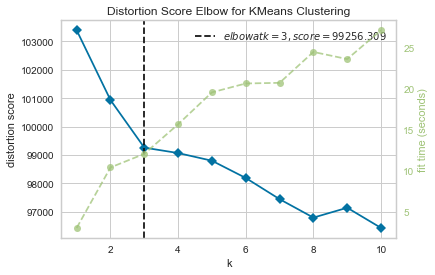

In [1004]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(1,11))

visualizer.fit(X)
visualizer.show()

We visualize the clusters of elbow method.

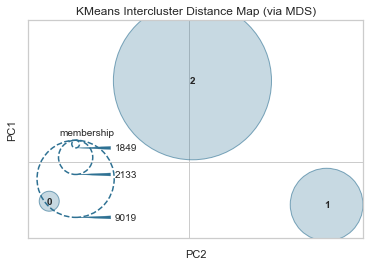

In [1005]:
from sklearn.datasets import make_blobs

from yellowbrick.cluster import InterclusterDistance

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Generate synthetic dataset with 12 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=12, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans(6)
visualizer = InterclusterDistance(kmeans)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

We use silhouette score to find the best number of clusters.

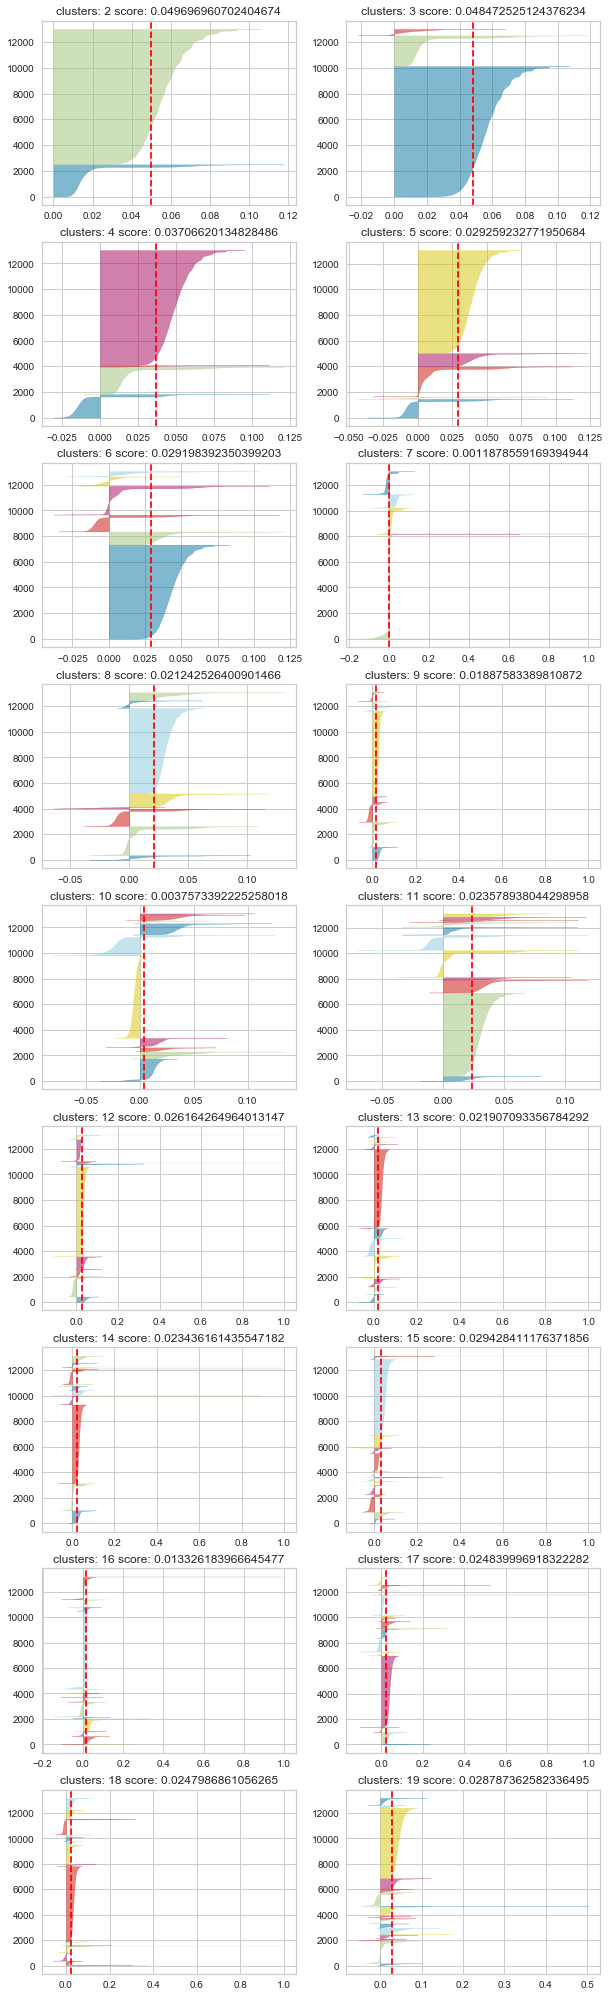

In [960]:
from yellowbrick.cluster import SilhouetteVisualizer

X = vect.fit_transform(corpus)
plt.figure(figsize=(2 * 5,  10 * 4))

scores = {}
for n_clusters in range(2, 20):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

We sort all the scores.

In [961]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.049696960702404674),
 (3, 0.048472525124376234),
 (4, 0.03706620134828486),
 (15, 0.029428411176371856),
 (5, 0.029259232771950684),
 (6, 0.029198392350399203),
 (19, 0.028787362582336495),
 (12, 0.026164264964013147),
 (17, 0.024839996918322282),
 (18, 0.0247986861056265),
 (11, 0.023578938044298958),
 (14, 0.023436161435547182),
 (13, 0.021907093356784292),
 (8, 0.021242526400901466),
 (9, 0.01887583389810872),
 (16, 0.013326183966645477),
 (10, 0.0037573392225258018),
 (7, 0.0011878559169394944)]

We visualize the clusters of silhouette scores.

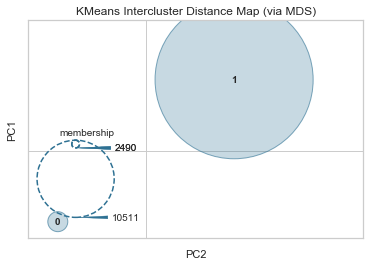

In [962]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)

# Generate synthetic dataset with 12 random clusters
X, y = make_blobs(n_samples=1000, n_features=12, centers=12, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=2, random_state=0)
visualizer = InterclusterDistance(kmeans)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The best number of clusters is 2 as the difference between 2 is better than 3 in silhouette.

We find the cluster centers of the 2 clusters.

In [963]:
X = vect.fit_transform(corpus)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[0.00040161, 0.00120482, 0.00200803, ..., 0.00120482, 0.00120482,
        0.00200803],
       [0.00104652, 0.00066597, 0.00304443, ..., 0.00095138, 0.00066597,
        0.00171249]])

We create 2 dataframes, one for every cluster.

In [964]:
voc_cent1 = pd.DataFrame(list(vect.vocabulary_.items()),columns = ['word','index']) 
voc_cent1 = voc_cent1.set_index('index')
voc_cent2 = pd.DataFrame(list(vect.vocabulary_.items()),columns = ['word','index']) 
voc_cent2 = voc_cent2.set_index('index')

We create 2 dataframes for the cluster centers.

In [965]:
cc1 = pd.DataFrame(cluster_centers[0], columns=['cvalue'])
cc2 = pd.DataFrame(cluster_centers[1], columns=['cvalue'])

We join the dataframes we created for every cluster.

In [966]:
cc1=cc1.merge(voc_cent1, right_index=True, left_index=True)
cc2=cc2.merge(voc_cent2, right_index=True, left_index=True)

We sort the dataframes based on the cluster centers. We print the top 20 dimensions of every cluster.

In [967]:
cc1=cc1.sort_values(by=['cvalue'], ascending = False)
cc2=cc2.sort_values(by=['cvalue'], ascending = False)
print(cc1.head(20), '\n')
print(cc2.head(20))

        cvalue        word
708   1.085141          eu
85    0.183133         amp
2228  0.125301          uk
1225  0.068273       leave
1371  0.051406        meps
270   0.051004     cameron
2167  0.049398       today
1757  0.049398  referendum
1195  0.043373      labour
2229  0.039759        ukip
244   0.039759     britain
1445  0.038554        need
1568  0.038153      people
695   0.037751    eppgroup
2293  0.037349        vote
2078  0.036145     support
1168  0.035743        just
2188  0.035341       trade
732   0.035341    european
2217  0.034940      turkey 

        cvalue        word
85    0.156312         amp
2229  0.096946        ukip
2167  0.068595       today
695   0.062791    eppgroup
732   0.060889    european
730   0.058130      europe
1568  0.045286      people
2293  0.043954        vote
930   0.042337       great
683   0.041575          ep
2214  0.038531        ttip
1361  0.037009     meeting
919   0.035962        good
1195  0.035772      labour
1371  0.035201        meps

It is very difficult to understand to which MEP group(s) belongs each cluster. We can just understand that 
they concern Eupean Union.

# Classification

We split your data to training and testing datasets.

In [969]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.text, data.origMepGroupShort,
                                                    test_size=0.2,random_state=42)

We run a pipeline that includes count vectorizer, tf-idf transformer and multinomial Naive Bayes classifier.

In [988]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

text_clf1 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

We train the algorithm.

In [989]:
text_clf1.fit(X_train, y_train)
predicted = text_clf1.predict(X_test)
np.mean(predicted == y_test)

0.5759323337178008

We run a pipeline that includes count vectorizer, tf-idf transformer 
and Stohactic Gradient Descent classifier.

In [990]:
from sklearn.linear_model import SGDClassifier

text_clf2 = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier())
                    ])
text_clf2.fit(X_train, y_train)
predicted = text_clf2.predict(X_test)
np.mean(predicted == y_test)

0.7435601691657054

We run cross validation for the 2 different algorithms with with 5 folds on the traing dataset.
We calculate the mean and the standard error of the mean (SEM) of the scores.

In [991]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(text_clf1, X_train, y_train, cv=5)
scores

array([0.5837734 , 0.56511293, 0.56682692, 0.56998557, 0.56812711])

In [992]:
from scipy.stats import sem

print(np.mean(scores), sem(scores))

0.5707651859376427 0.003348424603733294


In [993]:
scores = cross_val_score(text_clf2, X_train, y_train, cv=5)
scores

array([0.72395583, 0.716963  , 0.73557692, 0.72919673, 0.7231584 ])

In [994]:
print(np.mean(scores), sem(scores))

0.7257701770611982 0.003127244283062686


The best algorithm is SGD because the mean score of the cross validation is 0.70 > 0.58.

We set the parameters to try with Grid Search.

We run Grid Search to find the best hyperparameters.\n
(We try some of the values and parameters to reach the deadline.)

In [977]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range':[(1,1),(1,2)],
              'vect__min_df':(0, 5, 10),
              'vect__max_df':(0.5, 0.75, 1.0),
              'tfidf__use_idf':(True,False),
              'clf__alpha': (1e-1, 1e-2, 1e-3)              
             }
gs_clf = GridSearchCV(text_clf2, parameters, n_jobs=-1, cv=5, verbose=10)
%time gs_clf = gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

Wall time: 4min 21s


We obtain the best parameter values. 

In [978]:
gs_clf.best_params_

{'clf__alpha': 0.001,
 'tfidf__use_idf': True,
 'vect__max_df': 0.5,
 'vect__min_df': 0,
 'vect__ngram_range': (1, 2)}

We set run the classifier again with the best parameter values we found. 

In [983]:
text_clf2 = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2),min_df=0,max_df=0.5)),
                     ('tfidf', TfidfTransformer(use_idf=True,)),
                     ('clf', SGDClassifier(alpha=0.001))
                    ])
text_clf2.fit(X_train, y_train)
predicted = text_clf2.predict(X_test)
np.mean(predicted == y_test)

0.7320261437908496

We calculate the mean and the standard error of the mean (SEM) of the scores of the cross
validation on the training dataset. 

In [996]:
scores = cross_val_score(text_clf2, X_train, y_train, cv=5)
print(np.mean(scores), sem(scores))

0.7277901033606581 0.0032063200563819424


mean scores are better by 0.2% so the algorithm cannot be much better that with default parameters.

We print the classification report and the confusion matrix:\n
* Precision is the ratio of true positives over all reported positives,
* Recall is the ratio of of true positives over all actual positives,
* $F_1$ is the harmonic mean of the precision and the recall and
* Support is the number of instances reported in each class.
\n
* The confusion matrix is a matrix $C$ such that the entry in each cell $C[i, j]$ shows the number of observations that belong to class $i$ but are reported as being in class $j$.

In [997]:
print(metrics.classification_report(y_test, predicted))

print()
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

        ALDE       0.69      0.69      0.69       372
         ECR       0.72      0.46      0.56       245
        EFDD       0.73      0.93      0.82       657
         EPP       0.81      0.72      0.76       427
     GUE-NGL       0.80      0.63      0.70        62
  Greens-EFA       0.75      0.60      0.67       244
         S&D       0.75      0.77      0.76       594

    accuracy                           0.74      2601
   macro avg       0.75      0.69      0.71      2601
weighted avg       0.75      0.74      0.74      2601


[[258  12  29  26   0  15  32]
 [ 13 112  78   8   2   4  28]
 [ 11   5 612   2   3   1  23]
 [ 39  11  24 307   0  15  31]
 [  4   0   7   3  39   1   8]
 [ 25   8  18  13   0 146  34]
 [ 26   7  65  18   5  13 460]]


We report also the results of a baseline classifier, Dummy Classifier to 
gauge the efficacy of the SGD Classifier.

In [998]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [999]:
scores = cross_val_score(dummy_clf, X_train, y_train, cv=5)
print(np.mean(scores), sem(scores))

0.18720911927504807 0.004036356045671738


In [1000]:
predicted = dummy_clf.predict(X_test)
np.mean(predicted == y_test)

0.18262206843521722

In [1001]:
print(metrics.classification_report(y_test, predicted))

print()
print(metrics.confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

        ALDE       0.12      0.13      0.13       372
         ECR       0.10      0.09      0.09       245
        EFDD       0.26      0.27      0.26       657
         EPP       0.19      0.19      0.19       427
     GUE-NGL       0.00      0.00      0.00        62
  Greens-EFA       0.12      0.12      0.12       244
         S&D       0.21      0.20      0.21       594

    accuracy                           0.18      2601
   macro avg       0.14      0.14      0.14      2601
weighted avg       0.18      0.18      0.18      2601


[[ 47  30 100  62   8  37  88]
 [ 40  22  64  33   3  28  55]
 [ 96  59 176 115  13  58 140]
 [ 73  37  98  81  16  30  92]
 [  5   9  11  12   0   4  21]
 [ 33  25  53  40   7  29  57]
 [ 84  49 177  91  11  62 120]]


We reported the same scores as after running SGD Classifier but all of the scores are much
lower now. That means that SGD algorithm makes very good predictions on the given dataset.